In [70]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

import json

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# importing my model functions for analysis
from psi_transmission.model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Organization of the data files

In a new directory, at data_main/sorted, I have copied only the good run files (with this determination precipitating from the work in the parsing_elog notebooks). I have renamed every .tof and every .txt file according to the following convention: inheritedFileName_configuration_runtype.tof(txt). Here are my conventions for configuration and runtype:

- NORM - normalization
- JPTI - JP Ti guide with NiP
- JPSU - JP SUS guide with NiP
- DISK - SS Disk
- GD01 - UGD01 guide
- GD03 - UGD03 guide
- EPSU - EP SUS guide with NiP


- s005 - 5 second storage measurement
- s020 - 20 second storage measurement
- s100 - 100 second storage measurement
- shot - direct shot measurement

For example:

T101217_0222_EPSU_s100.tof

T091217_0130_NORM_s100.txt

### Master Run List:

Run #'s                      | Day |  Storage Time (s)   | Configuration          |
---                          | --- |      ---            | ---                    |
--- - 21                     | 8   |      n/a            | BAD                    |
 22 - 24                     | 8   |       20            | normalization          |
 25 - 31                     | 8   |      100            | normalization          |
 32 - 35*                    | 8   |        5            | normalization          |
      48                     | 8   |   direct            | JP SUS guide with NiP  |
      49                     | 8   |   direct            | BAD                    |
 50 - 60                     | 8   |      100            | JP SUS guide with NiP  |
 61 - 63                     | 8   |        5            | JP SUS guide with NiP  |
 64 - 66*                    | 8   |       20            | JP SUS guide with NiP  |
      76                     | 8   |   direct            | normalization          |
 77 - 79                     | 8   |        5            | normalization          |
 80 - 82                     | 8   |       20            | normalization          |
 83 - 88$^\dagger$           | 8   |      100            | normalization          |
      98                     | 8   |   direct            | JP Ti guide with NiP   |
 99 - 105                    | 8   |      100            | JP Ti guide with NiP   |
  1 - 90                     | 9   |      100            | JP Ti guide with NiP   |
 99 - 101                    | 9   |       20            | JP Ti guide with NiP   |
102 - 110                    | 9   |        5            | JP Ti guide with NiP   |
      120                    | 9   |   direct            | normalization          |
121 - 123                    | 9   |        5            | normalization          |
124 - 125                    | 9   |       20            | normalization          |
      126                    | 9   |       20            | BAD                    |
      127                    | 9   |       20            | normalization          |
128 - 135                    | 9   |      100            | normalization          |
      145                    | 9   |   direct            | SS disk                |
146 - 153                    | 9   |      100            | SS disk                |
154 - 156                    | 9   |       20            | SS disk                |
157 - 159                    | 9   |        5            | SS disk                |
      175                    | 9   |   direct            | normalization          |
176 - 183                    | 9   |      100            | normalization          |
184 - 186                    | 9   |       20            | normalization          |
187 - 189                    | 9   |        5            | normalization          |
      198                    | 9   |   direct            | UGD01                  |
      199                    | 9   |      100            | UGD01                  |
  1 - 107                    | 10  |      100            | UGD01                  |
108 - 110                    | 10  |       20            | UGD01                  |
111 - 113                    | 10  |        5            | UGD01                  |
      122                    | 10  |   direct            | normalization          |
123 - 130                    | 10  |      100            | normalization          |
131 - 133                    | 10  |       20            | normalization          |
134 - 136                    | 10  |        5            | normalization          |
      145                    | 10  |   direct            | UGD03                  |
146 - 155                    | 10  |      100            | UGD03                  |
156 - 158                    | 10  |       20            | UGD03                  |
159 - 161                    | 10  |        5            | UGD03                  |
      170                    | 10  |   direct            | normalization          |
      171                    | 10  |      BAD            | BAD                    |
172 - 179                    | 10  |      100            | normalization          |
180 - 182                    | 10  |       20            | normalization          |
183 - 185                    | 10  |        5            | normalization          |
193 - 194                    | 10  |   direct            | EP SUS guide with NiP  |
      195                    | 10  |      100            | EP SUS guide with NiP  |
196 - 198                    | 10  |        5            | EP SUS guide with NiP  |
199 - 201                    | 10  |       20            | EP SUS guide with NiP  |
202 - 241                    | 10  |      100            | EP SUS guide with NiP  |
      249                    | 10  |   direct            | normalization          |
250 - 252                    | 10  |        5            | normalization          |
253 - 255                    | 10  |       20            | normalization          |
256 - 265                    | 10  |      100            | normalization          |
273 - 274$^{\dagger\dagger}$ | 10  |   direct            | bad?                   |
275 - 278                    | 10  |       20            | bad?                   |
  1 -  93                    | 11  |       20            | bad?                   |

\* *configuration change, background included* <br/>
$^\dagger$ *to be checked in the data (remove noise at the end)* <br/>
$^{\dagger\dagger}$ *(we connect both plexi guides together, as at the beginning)*

## Loading Data

The function used to load the data should take a few strings that determine what types of runs and configuration we want. The function should just return an array with a row for each run, and the columns:

\[time_since_experiment_start, storage_time, integrated_counts\]

for direct shot measurements we can set the storage time to zero. See the function load_data_2() in the model.py file for such an implementation. An example of usage is given below

In [101]:
config = "NORM"
run_type = "s005"

data = load_data_2(config, run_type)
print('Here is the returned array:\n')
data

Here is the returned array:



array([[2.16204000e+05, 5.00000000e+00, 7.71850000e+04, 2.77821885e+02],
       [2.60077000e+05, 5.00000000e+00, 6.98120000e+04, 2.64219606e+02],
       [1.82359000e+05, 5.00000000e+00, 9.39510000e+04, 3.06514274e+02],
       [2.75102000e+05, 5.00000000e+00, 6.75310000e+04, 2.59867274e+02],
       [2.16504000e+05, 5.00000000e+00, 7.71360000e+04, 2.77733685e+02],
       [2.59776000e+05, 5.00000000e+00, 6.95640000e+04, 2.63749882e+02],
       [2.15903000e+05, 5.00000000e+00, 7.70380000e+04, 2.77557201e+02],
       [1.82960000e+05, 5.00000000e+00, 9.39240000e+04, 3.06470227e+02],
       [1.82659000e+05, 5.00000000e+00, 9.39430000e+04, 3.06501223e+02],
       [1.24579000e+05, 5.00000000e+00, 1.04093000e+05, 3.22634468e+02],
       [2.59776000e+05, 5.00000000e+00, 6.95640000e+04, 2.63749882e+02],
       [1.11219000e+05, 5.00000000e+00, 1.04917000e+05, 3.23908938e+02],
       [1.10918000e+05, 5.00000000e+00, 1.05348000e+05, 3.24573566e+02],
       [2.74501000e+05, 5.00000000e+00, 6.74050000e

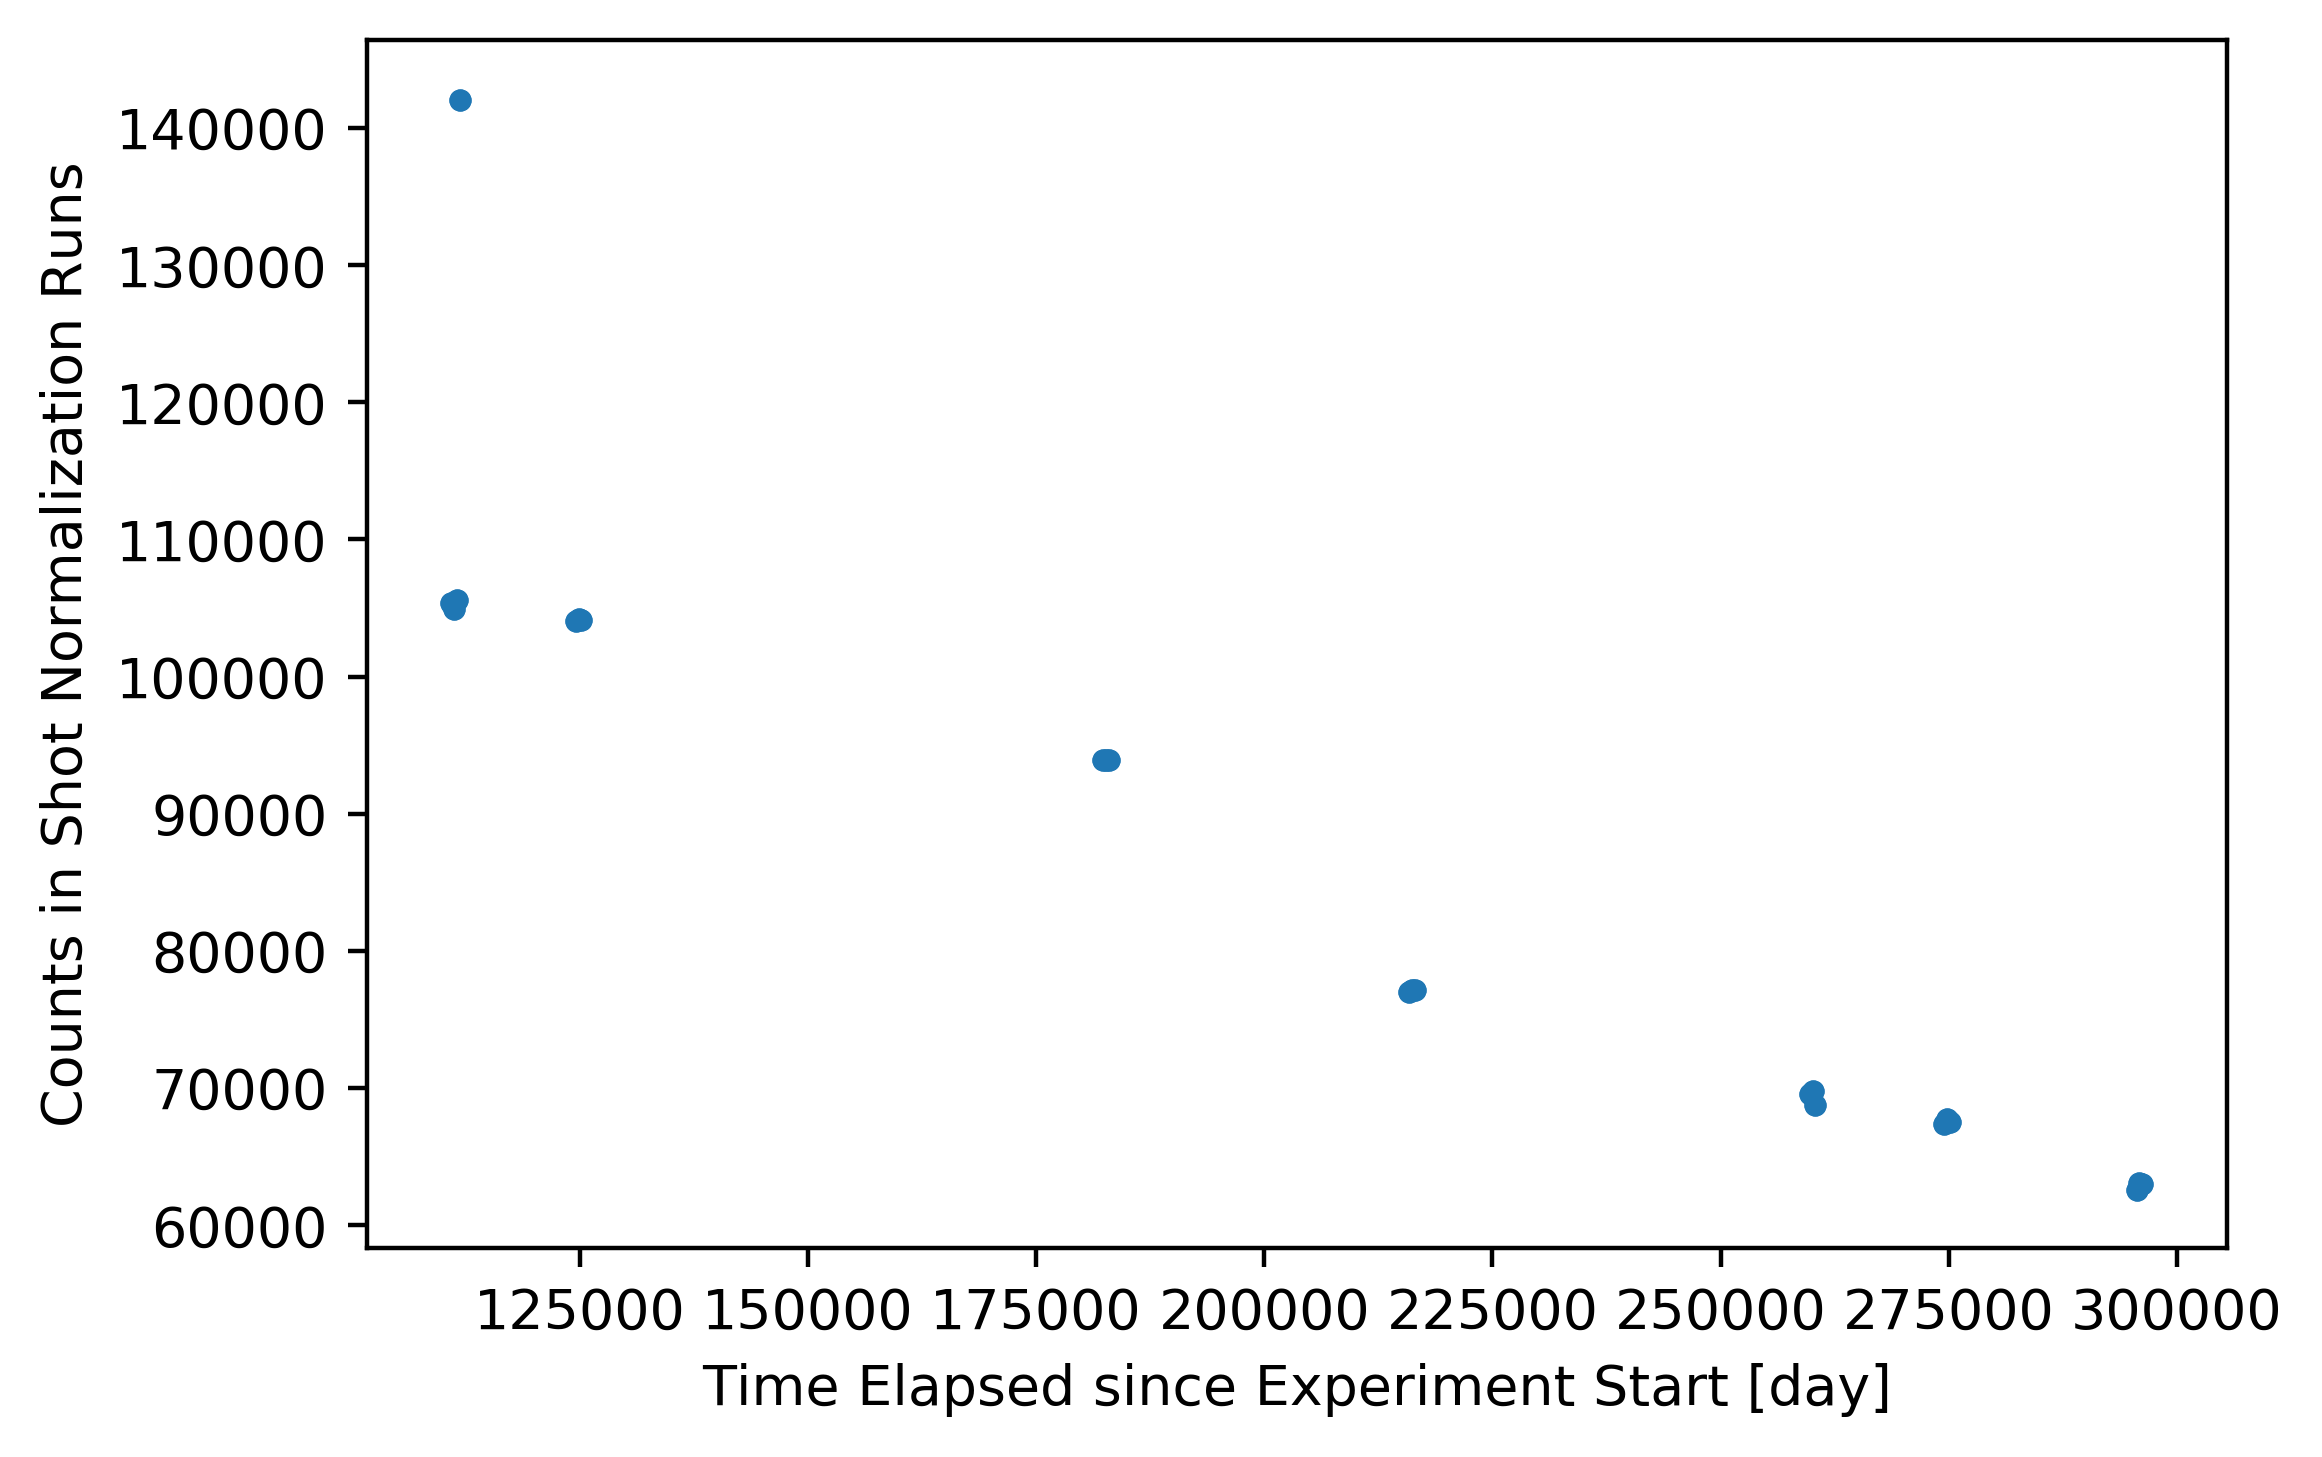

In [102]:
plt.errorbar(data[:,0], data[:,2], yerr = data[:,3], fmt = '.')
plt.xlabel('Time Elapsed since Experiment Start [day]')
plt.ylabel('Counts in Shot Normalization Runs');

## Cleaning data

There are a couple of runs that need unique attention. They are runs 35, 66, and 88, all on the 8th of December. The spectra are examined below, and specific cuts of the data are decided on. These cuts are implemented directly in the load_data_2() function.

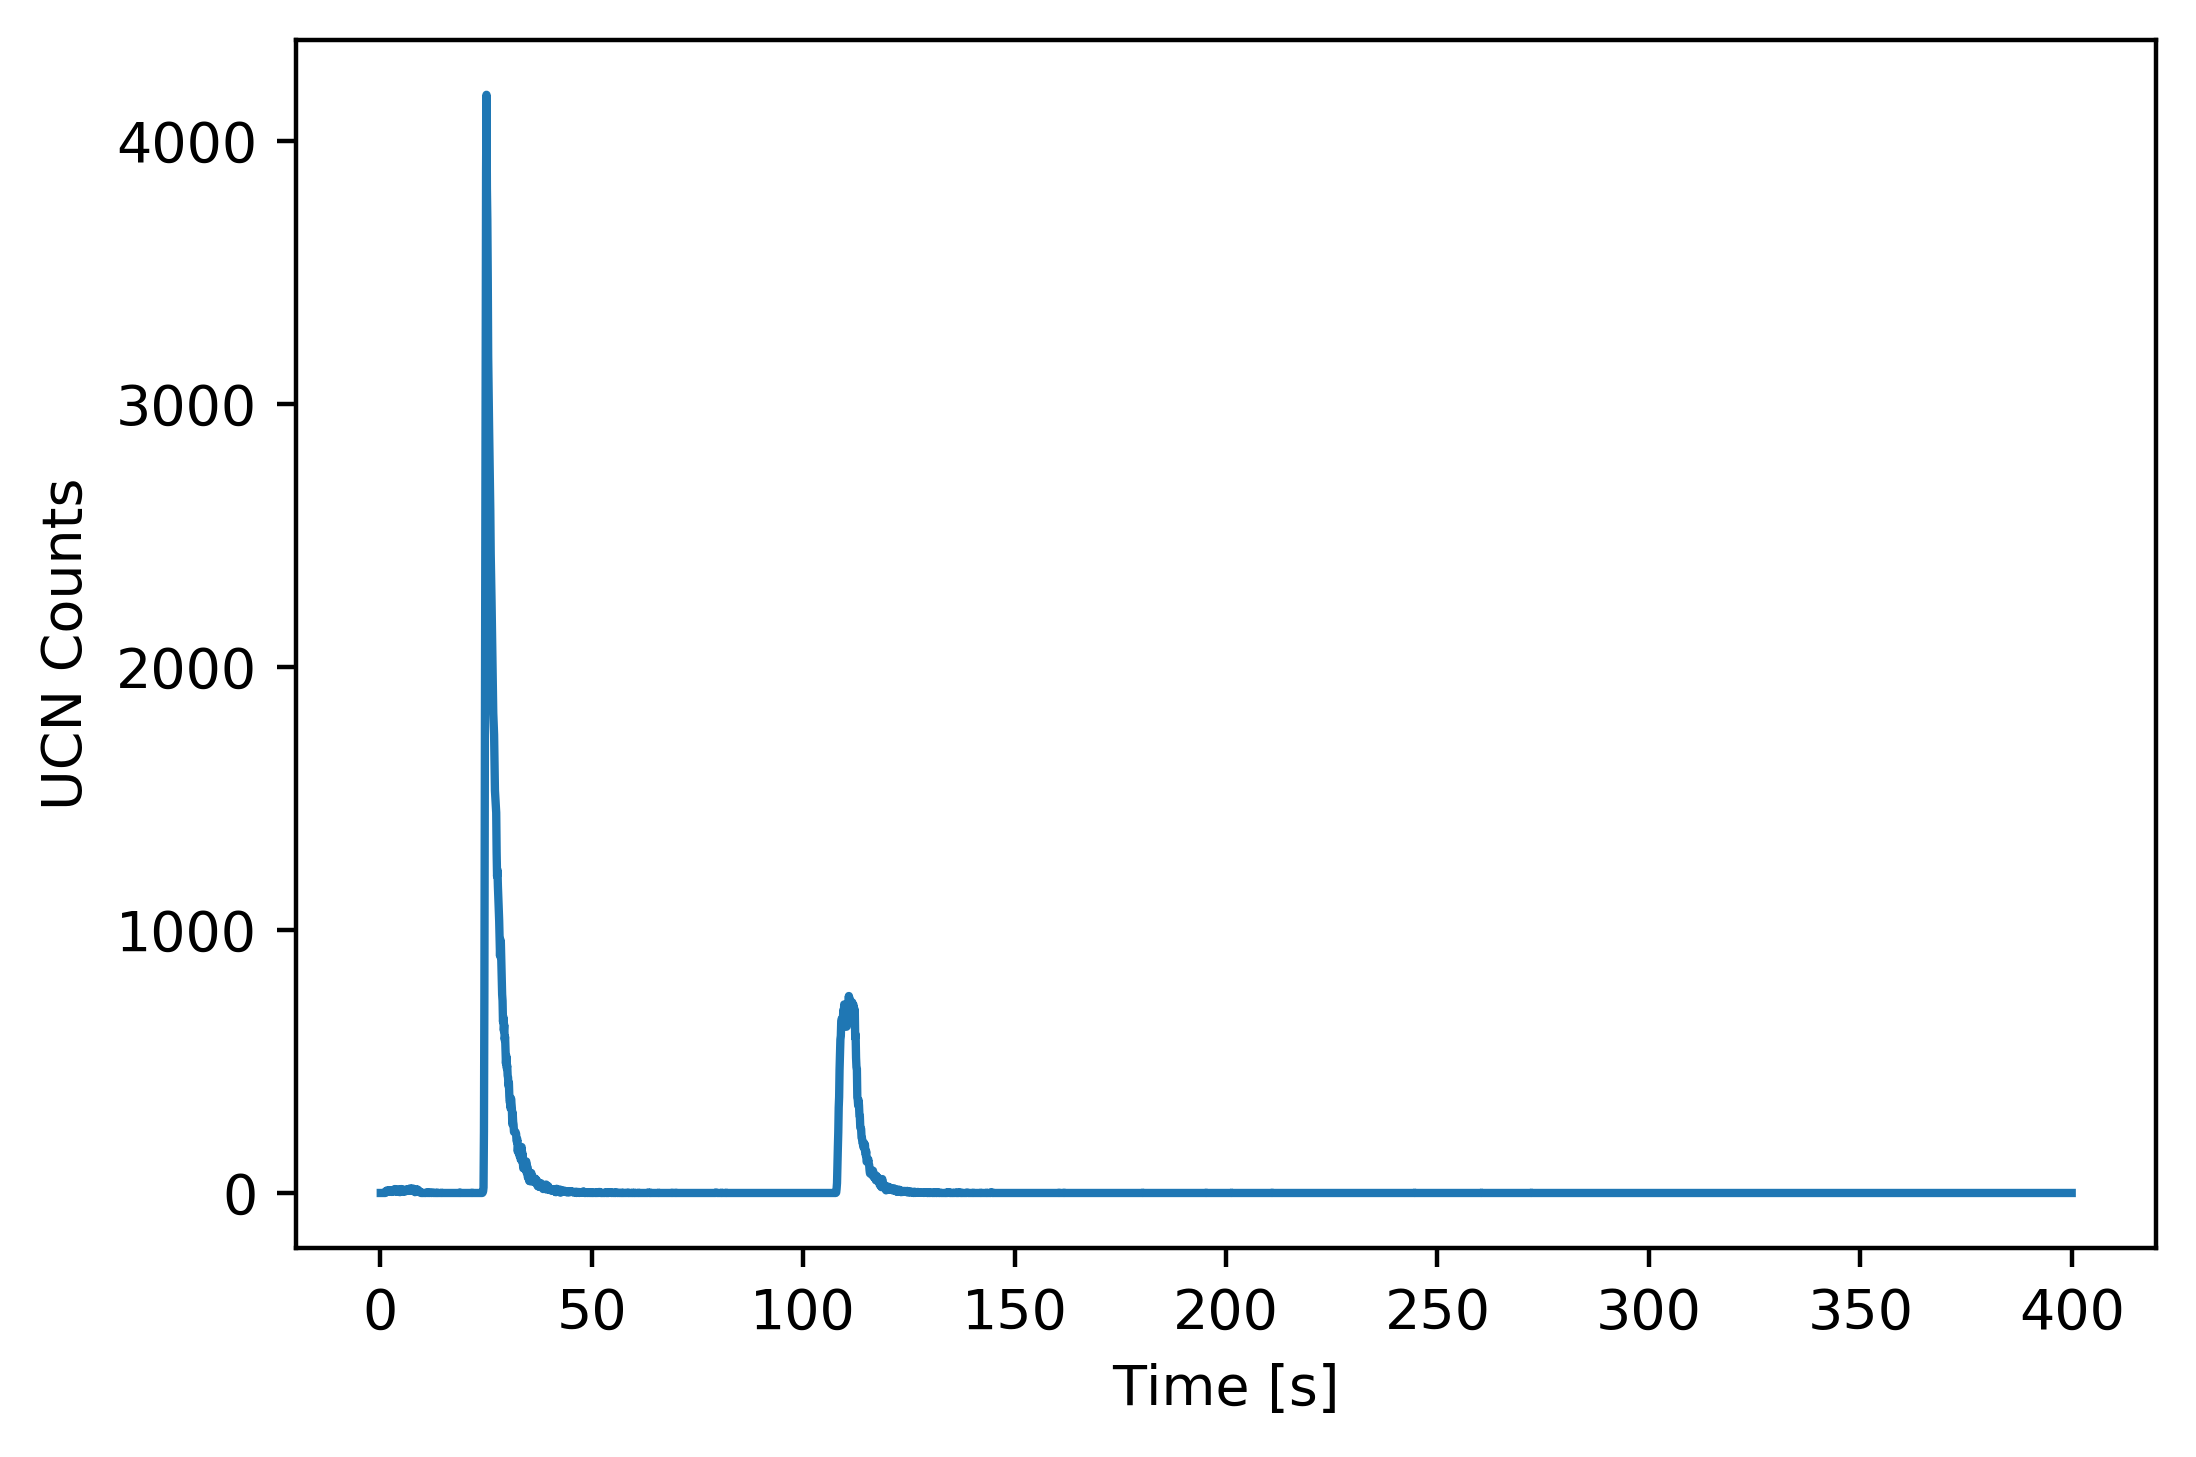

In [103]:
data = np.loadtxt("../data_main/12/8/T081217_0035.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.show()

Here we'll cut everything after 100 s.

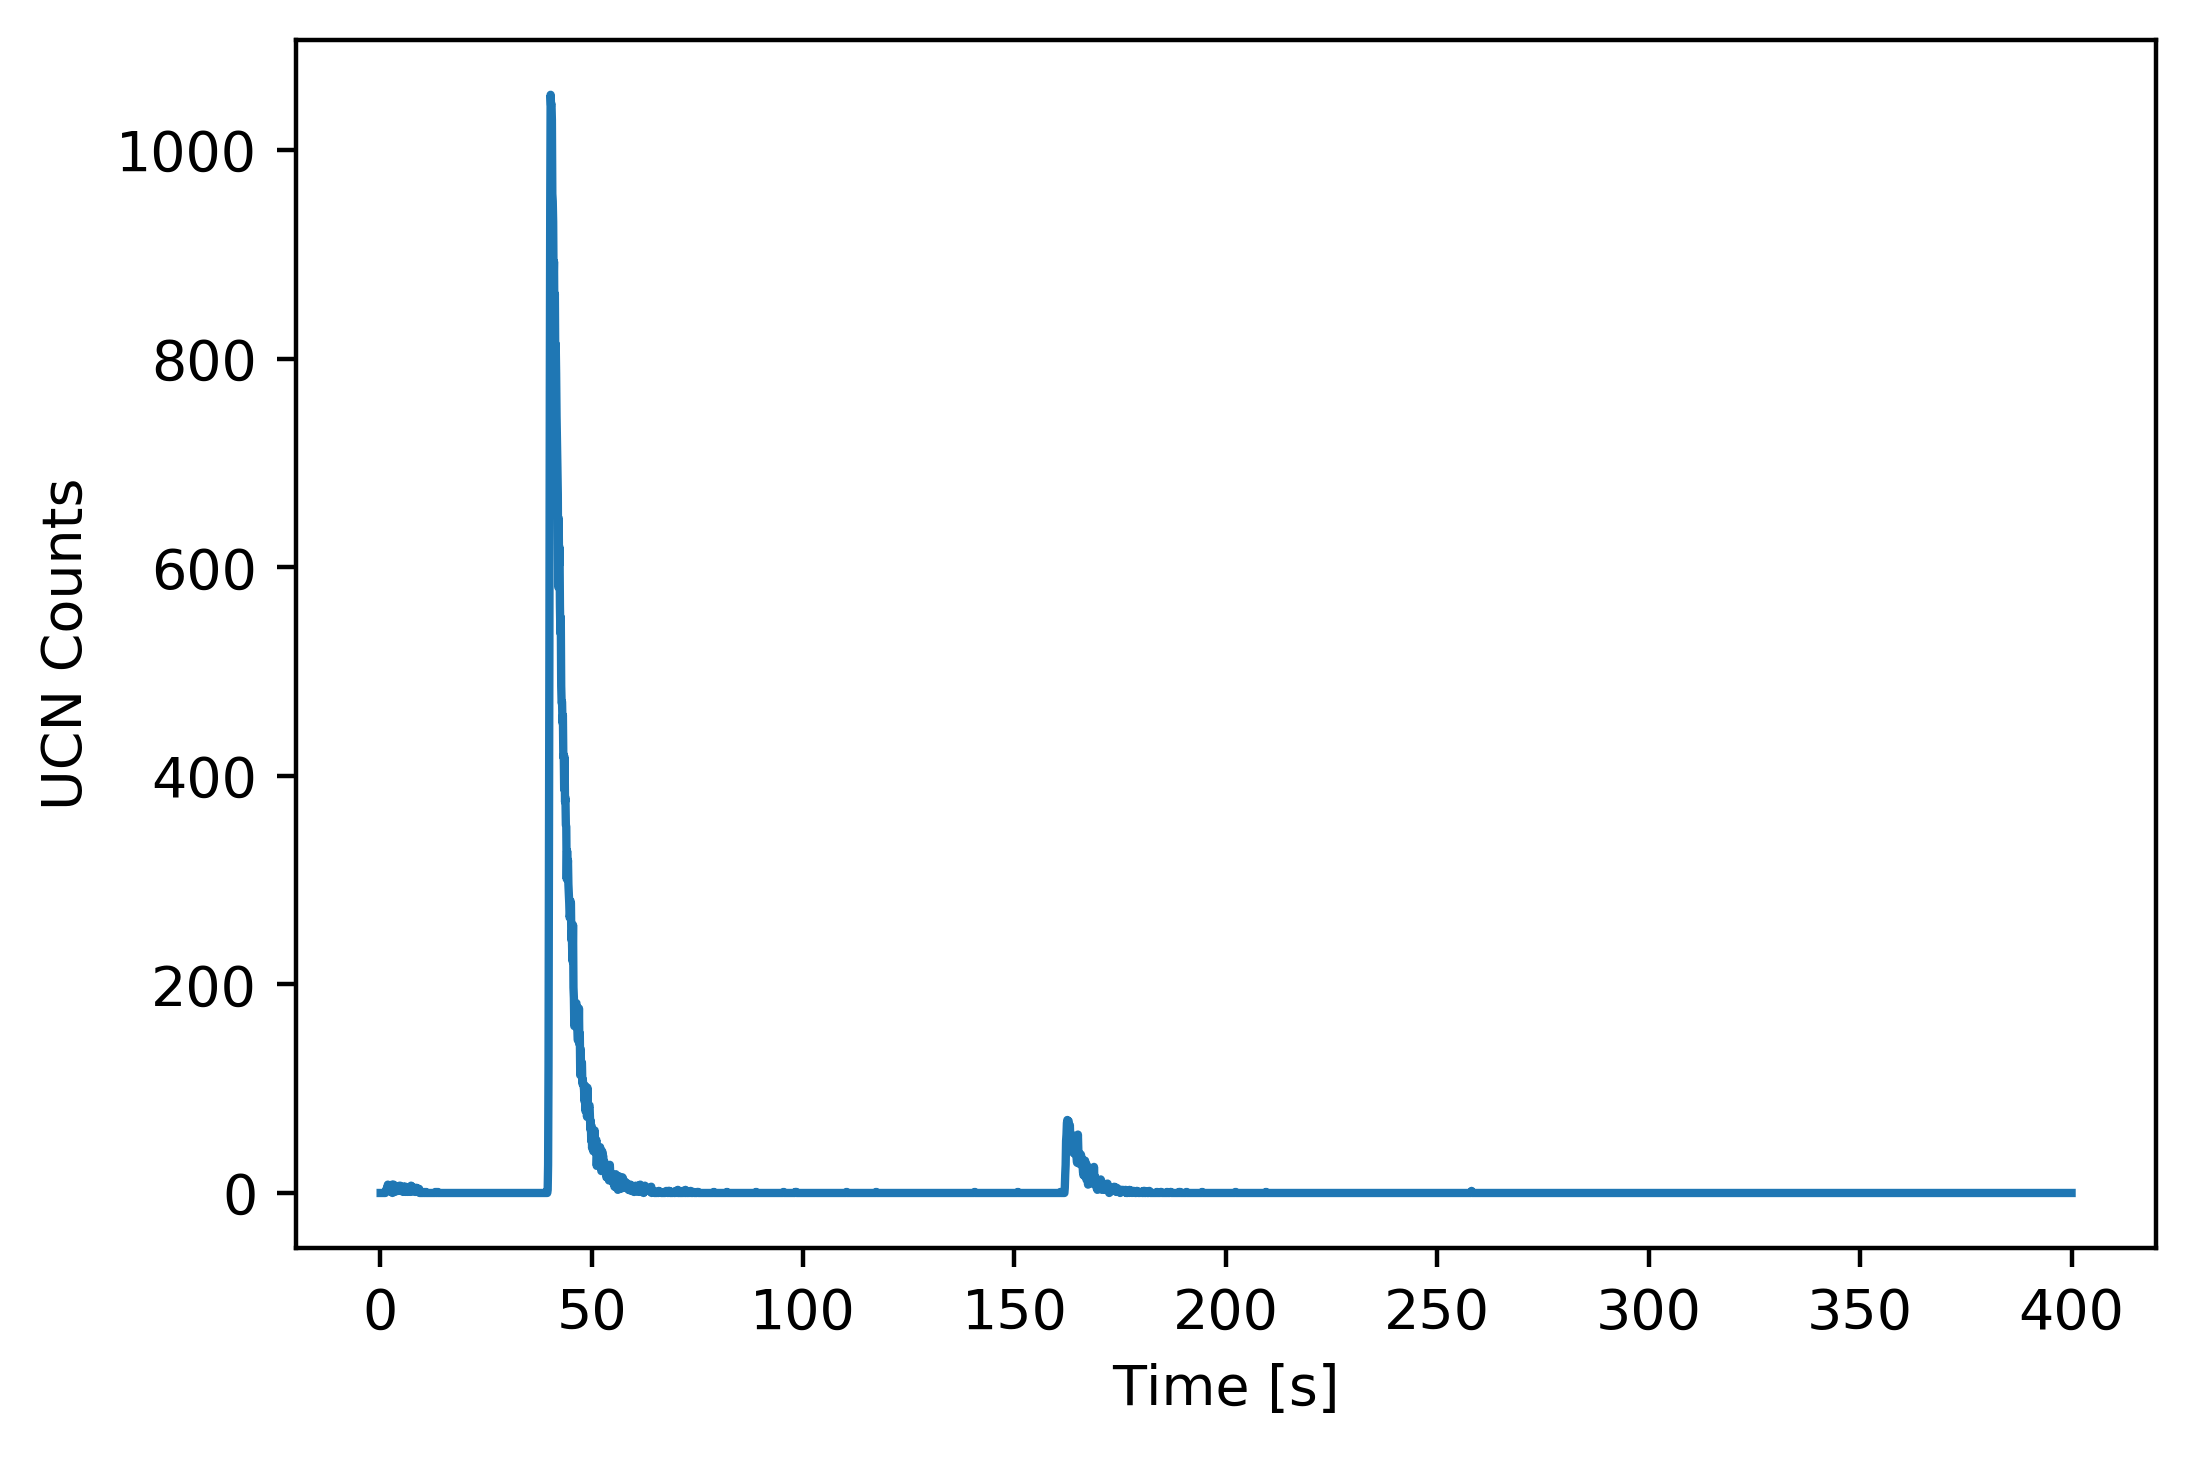

In [76]:
data = np.loadtxt("../data_main/12/8/T081217_0066.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.show()

Here in run 66, we'll cut everything after 150 seconds.

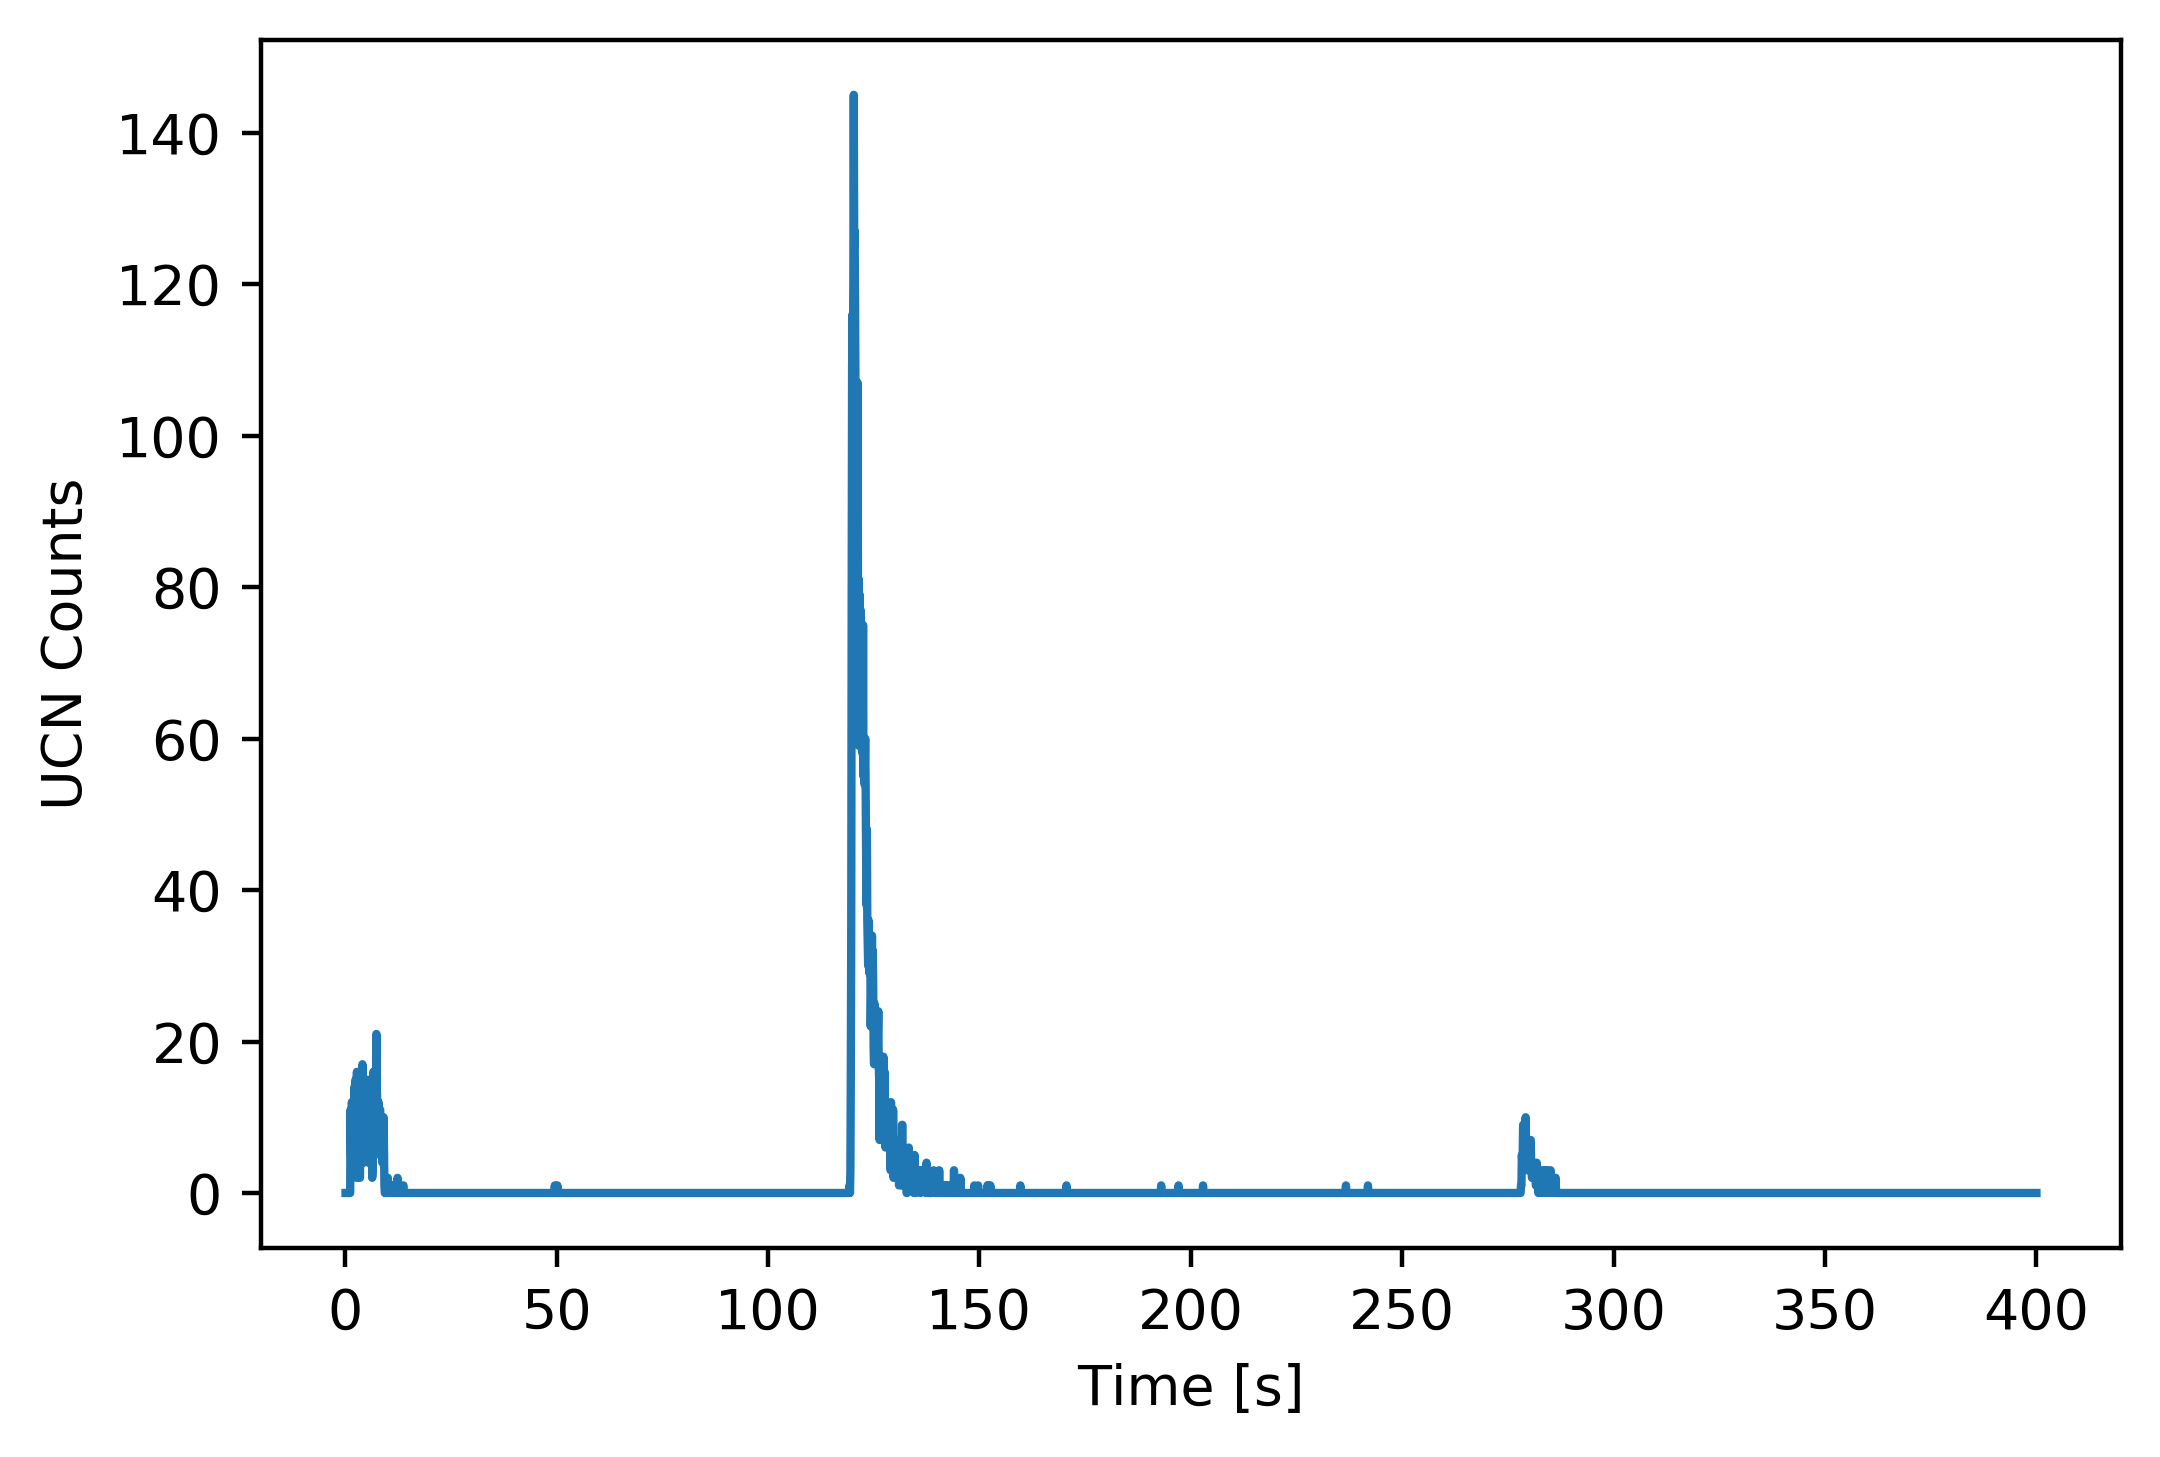

In [96]:
data = np.loadtxt("../data_main/12/8/T081217_0088.tof", usecols = (0,1));
plt.plot(data[:,0] * 0.1, data[:,1]);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.show()

Similarly here, everything after 250 seconds will be cut.